# Juan Carlos Perez Ramirez
## Procesamiento de Lenguaje Natural
## Tarea 3: Minería de Texto Básica

In [1]:
import os
import re
from keras.preprocessing.text import Tokenizer

def get_texts_from_file(path_corpus, path_truth):
    tr_txt = []
    tr_y = []

    with open(path_corpus, "r") as f_corpus, open(path_truth, "r") as f_truth:
        for tweet in f_corpus:
            tr_txt += [tweet]
        for label in f_truth:
            tr_y += [label]
    return tr_txt, tr_y

2025-02-23 15:08:33.922155: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-23 15:08:34.224959: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-23 15:08:34.226179: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-23 15:08:35.393808: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
tr_txt, tr_y = get_texts_from_file("../../Corpus/mex20_train.txt", "../../Corpus/mex20_train_labels.txt")
tr_y = list(map(int, tr_y))

In [3]:
from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer()

In [4]:
import nltk 
# cuenta la frecuencia de aparicion de palabras y las almacena en un diccionario
corpus_palabras = []
for doc in tr_txt:
    corpus_palabras += tokenizer.tokenize(doc)

fdist = nltk.FreqDist(corpus_palabras)

In [5]:
# Ordena el diccionario de mayor a menor frecuencia
def sortFreqDict(freqdict):
    aux = [(freqdict[key], key) for key in freqdict]
    aux.sort()
    aux.reverse()
    return aux

In [6]:
V = sortFreqDict(fdist)
V = V[:5000]

In [ ]:
# se guarda en un diccionario debido a su rapido acceso
dict_indices = dict()
cont = 0

for weight, word in V:
    dict_indices[word] = cont
    cont += 1

# BoW

In [8]:
import numpy as np

# Construccion de la matriz de BOW, donde cada fila es un documento y cada columna una palabra donde se indica si esta presente o no
def build_bow_tr(tr_txt, V, dict_indices):
    BOW = np.zeros((len(tr_txt), len(V)),dtype=int)
    cont_doc = 0
    for tr in tr_txt:
        fdist_doc = nltk.FreqDist(tokenizer.tokenize(tr))
        for word in fdist_doc:
            if word in dict_indices: # en caso de que la palabra no este en el diccionario recortado
                BOW[cont_doc, dict_indices[word]] = fdist_doc[word]
        cont_doc += 1
    return BOW

In [ ]:
BOW_tr = build_bow_tr(tr_txt, V, dict_indices)

# Compute TCOR

In [10]:
from math import log10
def compute_tcor(TR):
    TR_subset_in = TR

    DTR = np.zeros((TR_subset_in.shape[1], TR_subset_in.shape[1]), dtype=np.float64)
    print("DOR: Shape of the input matrix (BoT): ", TR.shape)
    print("DOR: Shape of the term-feat matrix: ", DTR.shape)

    tam_V = TR_subset_in.shape[1]
    for i in range(tam_V):
        nonzero_positions = np.nonzero(TR_subset_in[:,i])[0]
        if nonzero_positions.size == 0:
            DTR[i,:] = 0
        valid_docs = TR_subset_in[nonzero_positions] # documentos en los que ocurre el termino i
        for j in range(i+1,tam_V): # se aprovecha la simetria de la matriz
            count = len(np.nonzero(valid_docs[:,j])[0])
            if count != 0:
                DTR[i,j] = 1 + log10(count)
            else:
                DTR[i,j] = 0
            DTR[j,i] = DTR[i,j]
        sum_ocur = np.sum(valid_docs ,axis=0)
        tam_v = np.count_nonzero(sum_ocur[:i]) + np.count_nonzero(sum_ocur[i+1:]) # cuenta el numero de terminos con los que co-ocurre el termino i
        if tam_v == 0:
            DTR[i,:] = 0
        else:
            DTR[i,:] *= log10(tam_V/tam_v)
    return DTR

In [11]:
from sklearn import preprocessing
TCOR_base = compute_tcor(BOW_tr)
TCOR_base = preprocessing.normalize(TCOR_base, norm='l2')
TCOR_base

DOR: Shape of the input matrix (BoT):  (5278, 5000)
DOR: Shape of the term-feat matrix:  (5000, 5000)


array([[0.        , 0.04167009, 0.0414032 , ..., 0.01363255, 0.01047827,
        0.01047827],
       [0.04149157, 0.        , 0.04152016, ..., 0.01043338, 0.01043338,
        0.01043338],
       [0.04192994, 0.0422293 , 0.        , ..., 0.        , 0.        ,
        0.01061158],
       ...,
       [0.27498265, 0.21135765, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.19728556, 0.19728556, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.18544599, 0.18544599, 0.18544599, ..., 0.        , 0.        ,
        0.        ]])

In [13]:
from sklearn.feature_selection import SelectKBest, chi2

feats = SelectKBest(chi2, k=1000) # seleccion de las 1000 mejores caracteristicas
feats.fit(BOW_tr, tr_y) # se ajusta para los terminos mas relevantes

SelectKBest(k=1000, score_func=<function chi2 at 0x72626dd69000>)

In [14]:
best = feats.get_support(indices=True)

In [153]:
dict_indice_invertido = {}
for w in dict_indices:
    dict_indice_invertido[dict_indices[w]] = w 
t_words = [dict_indice_invertido[index] for index in best]

In [154]:
target_matrix = TCOR_base[best]
target_matrix = target_matrix[:,best]
target_matrix.shape

(1000, 1000)

In [155]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
reduced_matrix = tsne.fit_transform(target_matrix)

In [156]:
max_x = np.amax(reduced_matrix, axis=0)[0]
max_y = np.amax(reduced_matrix, axis=0)[1]

/home/juancho/.local/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 129315 (\N{ROLLING ON THE FLOOR LAUGHING}) missing from current font.
  func(*args, **kwargs)
/home/juancho/.local/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 127814 (\N{AUBERGINE}) missing from current font.
  func(*args, **kwargs)
/home/juancho/.local/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 128293 (\N{FIRE}) missing from current font.
  func(*args, **kwargs)
/home/juancho/.local/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 128579 (\N{UPSIDE-DOWN FACE}) missing from current font.
  func(*args, **kwargs)
/home/juancho/.local/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 128166 (\N{SPLASHING SWEAT SYMBOL}) missing from current font.
  func(*args, **kwargs)
/home/juancho/.local/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 128556 (\N{GRIMACIN

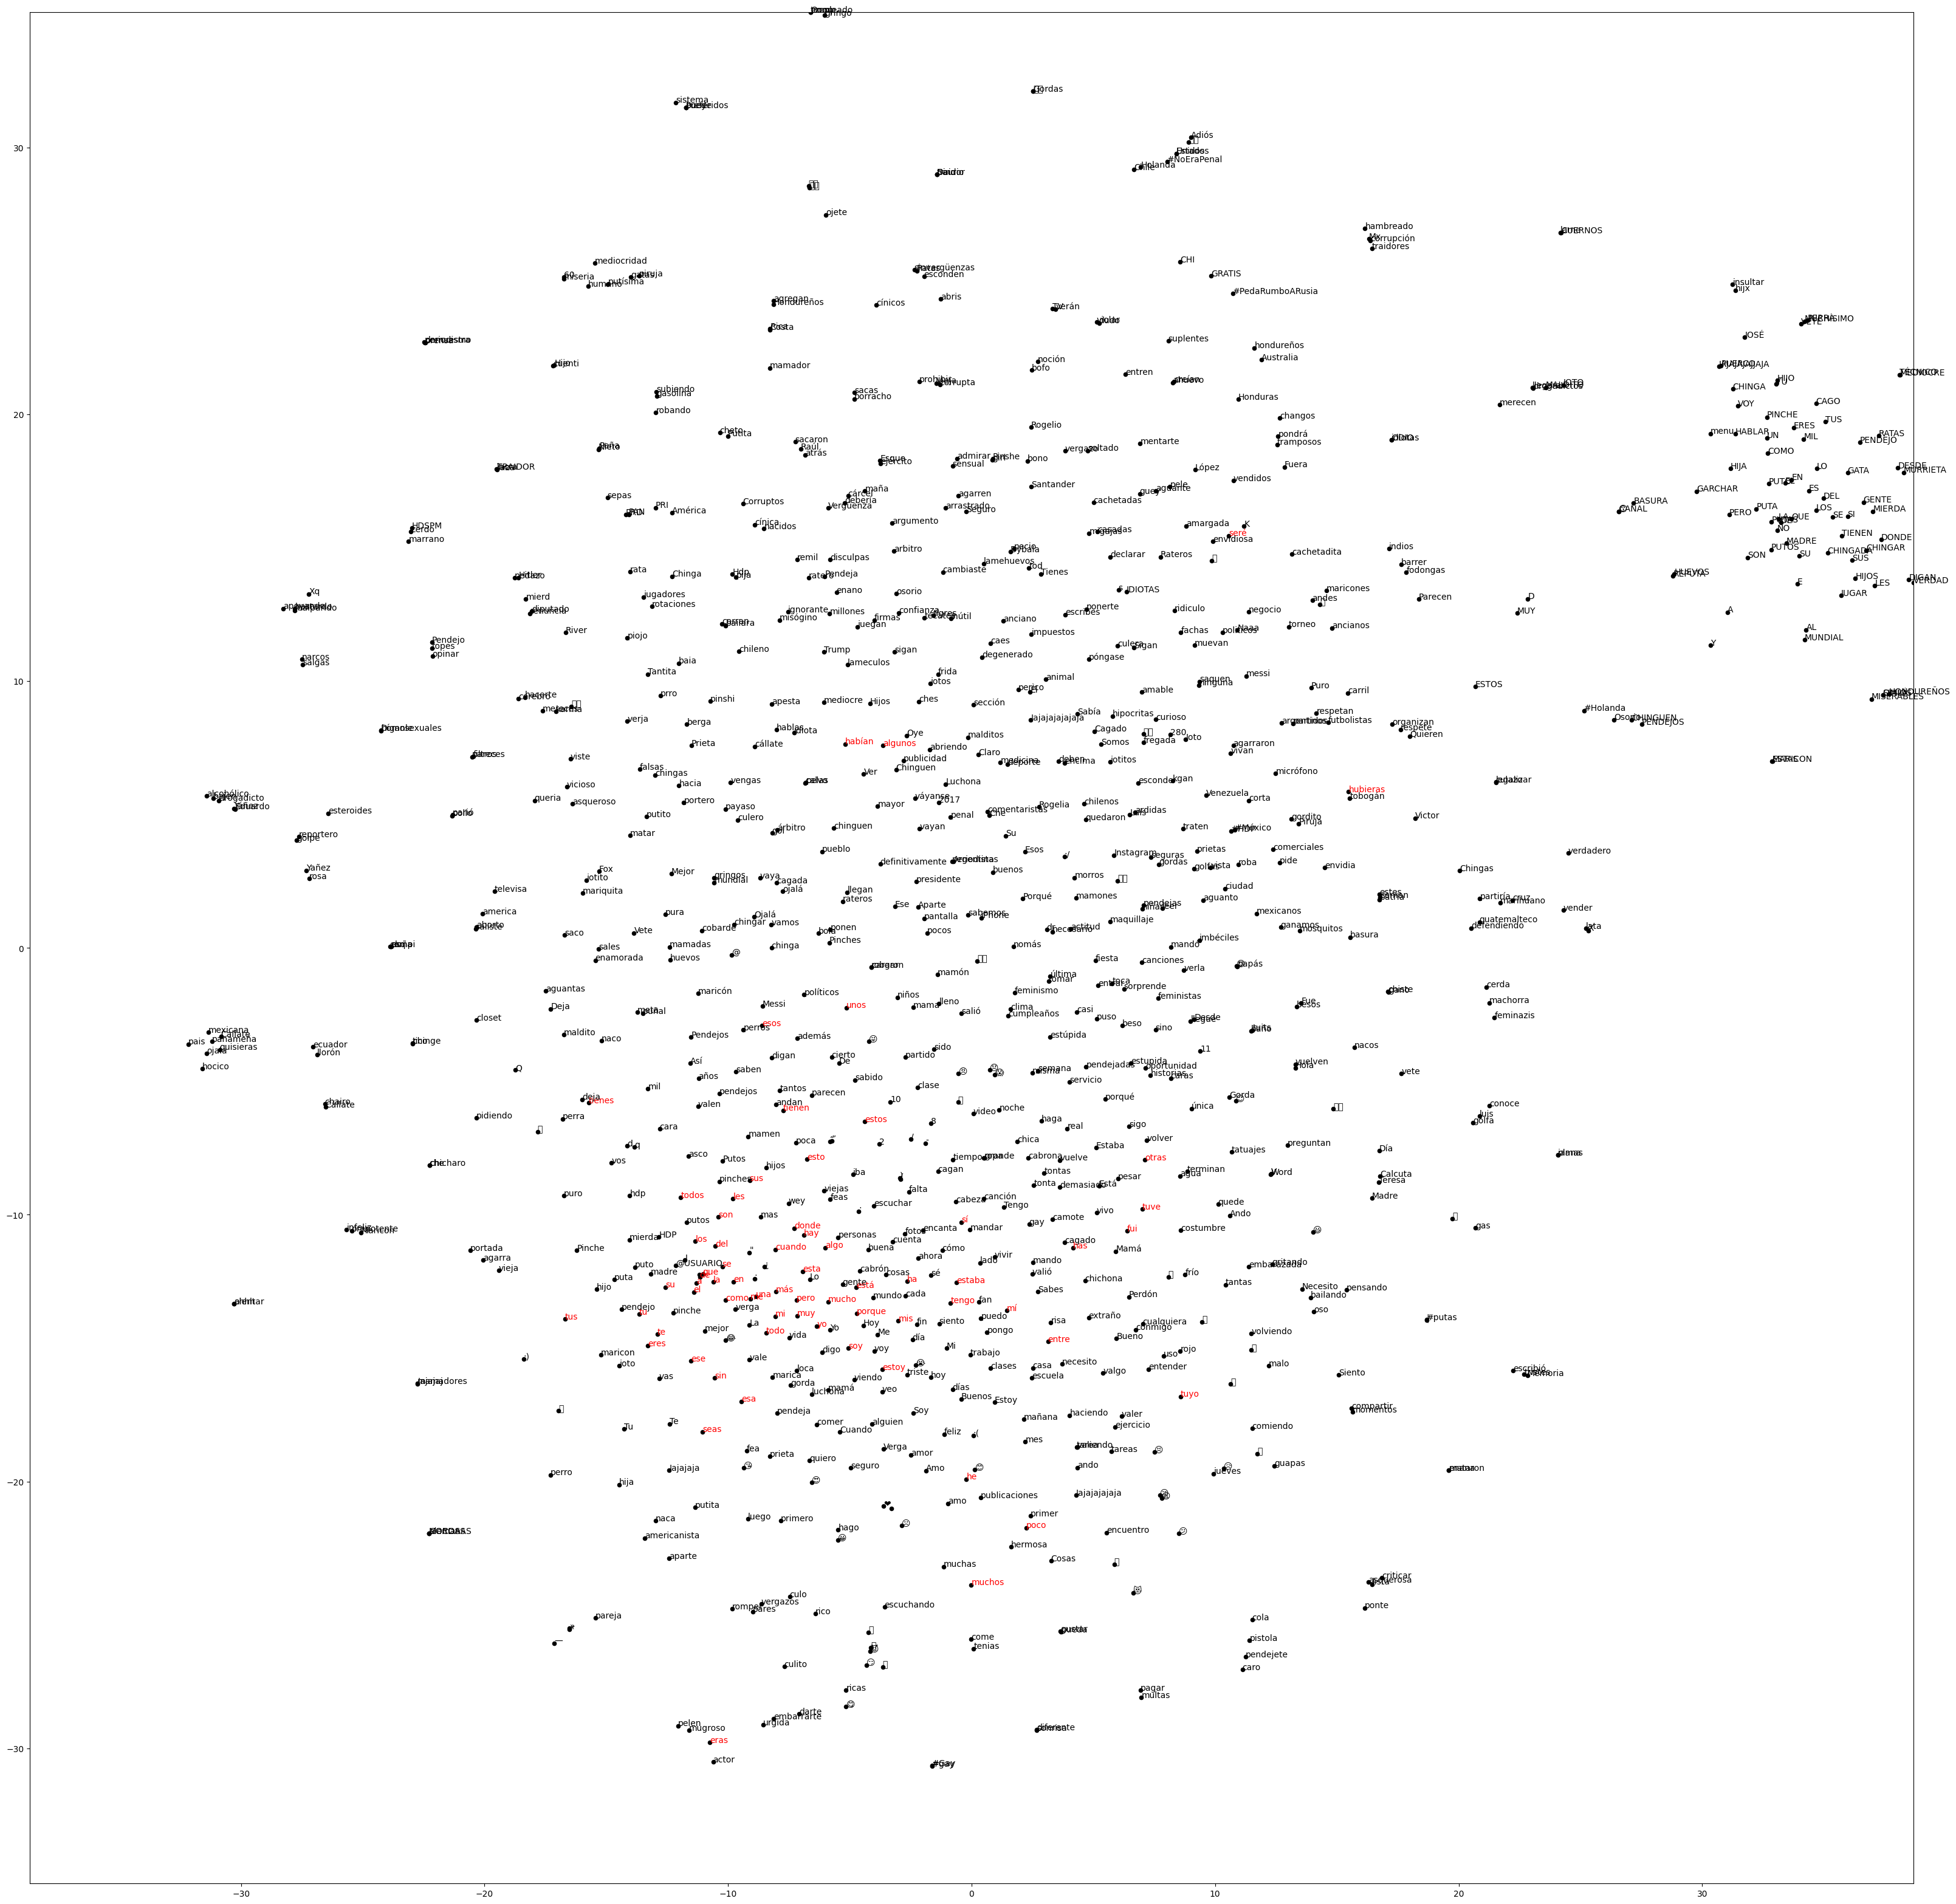

In [157]:
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
sw = set(stopwords.words("spanish"))

plt.figure(figsize=(40,40), dpi=100); plt.xlim(-max_x, max_x); plt.ylim(-max_y, max_y)
plt.scatter(reduced_matrix[:,0], reduced_matrix[:,1], 20, color='k')

for idx, word in enumerate(t_words):
    x = reduced_matrix[idx,0]
    y = reduced_matrix[idx,1]
    if word in sw:
        plt.annotate(word, (x,y), color='r')
    else:
        plt.annotate(word, (x,y), color='k')


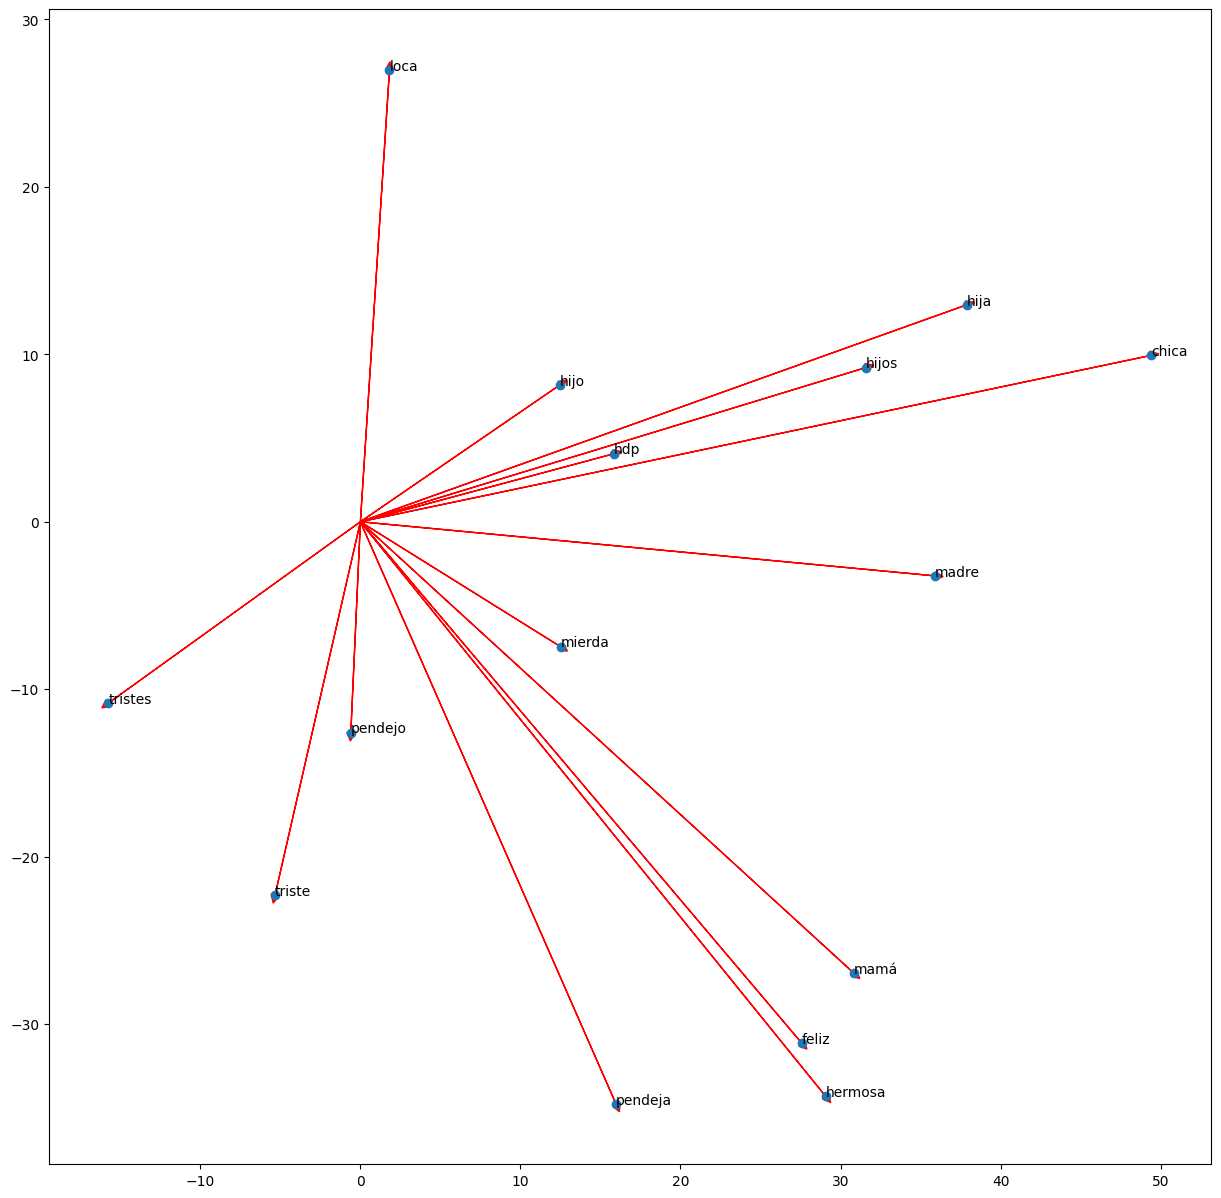

In [148]:
subsetwords = ["tristes", "triste", "feliz", "hermosa", "chica", "hombres", "hdp", "madre", "madres", "@usuario", "hijos", "pendeja", "pendejo", "mierda", "loca", "hijo", "hija", "mamá", "tía"]

ploted_subsetwords = []
subreduced_matrix = []
for idx, word in enumerate(t_words):
    if word in subsetwords:
        ploted_subsetwords += [word]
        subreduced_matrix += [reduced_matrix[idx]]

subreduced_matrix = np.array(subreduced_matrix)

fig, ax = plt.subplots(figsize=(15,15))

col1 = 0
col2 = 1

for word in subreduced_matrix:
    ax.arrow(0, 0, word[col1], word[col2], head_width=0.5, head_length=0.5, fc='r', ec='r')

ax.scatter(subreduced_matrix[:,0], subreduced_matrix[:,1])

for i in range(len(ploted_subsetwords)):
    ax.annotate(ploted_subsetwords[i], (subreduced_matrix[i,col1], subreduced_matrix[i,col2]))

plt.show()

# Random indexing

In [97]:
def compute_random_indexing(TR, rand_len=2000, nonzeros=0.1):
    TR_subset_in = TR  

    # construccion de vectores indice para los documentos
    num_docs = TR_subset_in.shape[0]
    doc_vectors = np.zeros((num_docs, rand_len), dtype=np.int64)
    num_nonzeros = int(rand_len * nonzeros)
    
    # asigna de forma aleatoria algunos indices no nulos para cada documento
    for i in range(num_docs):
        idx = np.random.choice(rand_len, num_nonzeros, replace=False)
        doc_vectors[i, idx] = np.random.choice([1, -1], size=num_nonzeros, replace=True)

    # construccion de los vectores de contexto para los indices
    num_terms = TR_subset_in.shape[1]
    term_vectors = np.zeros((num_terms, rand_len), dtype=np.int64)
    for w in range(num_terms):
        if np.count_nonzero(TR_subset_in[:, w]) == 0:
            continue
        else:
            aux = TR_subset_in[:, w][:, np.newaxis] * doc_vectors
            term_vectors[w] = np.sum(aux, axis=0)
    
    return term_vectors


In [61]:
from sklearn import preprocessing
context_vecs = compute_random_indexing(BOW_tr)
context_vecs = preprocessing.normalize(context_vecs, norm='l2')
context_vecs

array([[-0.01396205, -0.02233928, -0.01023884, ...,  0.        ,
         0.05212499,  0.01303125],
       [-0.01308529, -0.01417573, -0.0403463 , ..., -0.05561247,
         0.03598454, -0.01090441],
       [-0.00530433, -0.01060866, -0.01060866, ..., -0.01166953,
        -0.0031826 ,  0.01166953],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.05050763,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [ ]:
target_matrix = context_vecs[best,:] # se filtran los renglones de la DTR que corresponden a los terminos seleccionados
target_matrix.shape

(1000, 2000)

In [63]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
reduced_matrix = tsne.fit_transform(target_matrix)

In [64]:
max_x = np.amax(reduced_matrix, axis=0)[0]
max_y = np.amax(reduced_matrix, axis=0)[1]

/home/juancho/.local/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 129315 (\N{ROLLING ON THE FLOOR LAUGHING}) missing from current font.
  func(*args, **kwargs)
/home/juancho/.local/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 127814 (\N{AUBERGINE}) missing from current font.
  func(*args, **kwargs)
/home/juancho/.local/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 128293 (\N{FIRE}) missing from current font.
  func(*args, **kwargs)
/home/juancho/.local/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 128579 (\N{UPSIDE-DOWN FACE}) missing from current font.
  func(*args, **kwargs)
/home/juancho/.local/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 128166 (\N{SPLASHING SWEAT SYMBOL}) missing from current font.
  func(*args, **kwargs)
/home/juancho/.local/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 128556 (\N{GRIMACIN

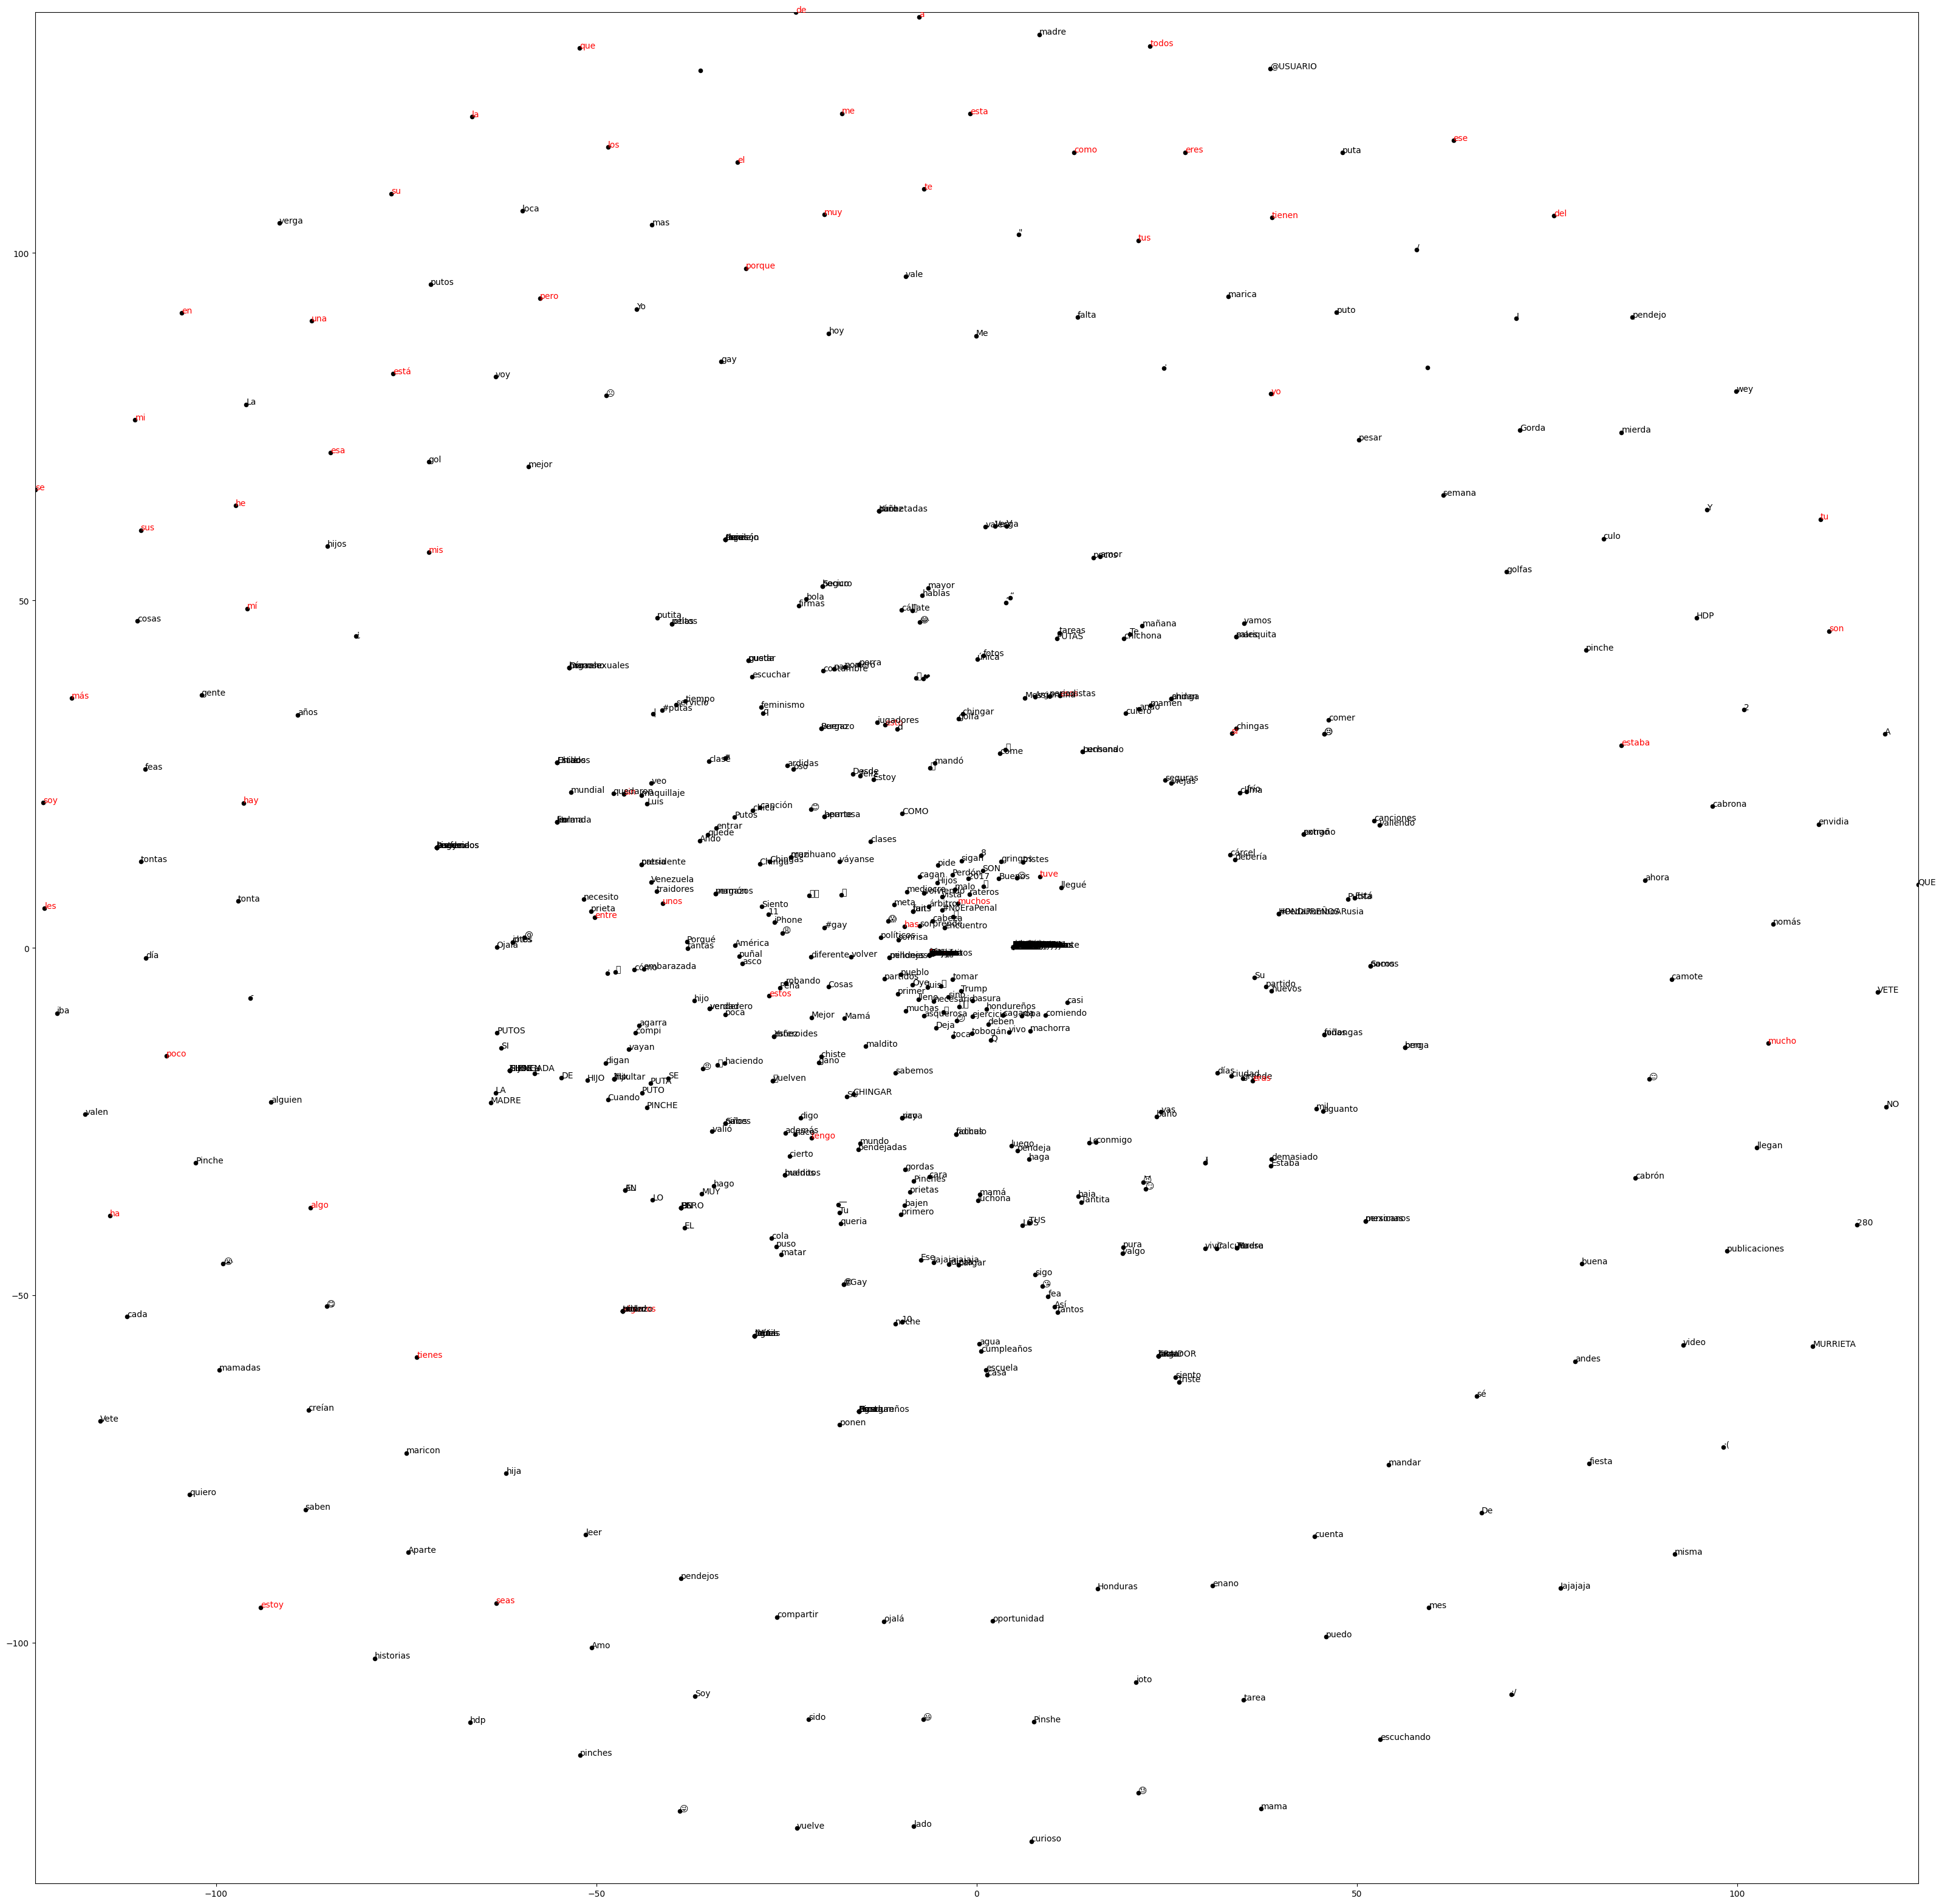

In [58]:
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
sw = set(stopwords.words("spanish"))

plt.figure(figsize=(40,40), dpi=100); plt.xlim(-max_x, max_x); plt.ylim(-max_y, max_y)
plt.scatter(reduced_matrix[:,0], reduced_matrix[:,1], 20, color='k')

for idx, word in enumerate(t_words):
    x = reduced_matrix[idx,0]
    y = reduced_matrix[idx,1]
    if word in sw:
        plt.annotate(word, (x,y), color='r')
    else:
        plt.annotate(word, (x,y), color='k')

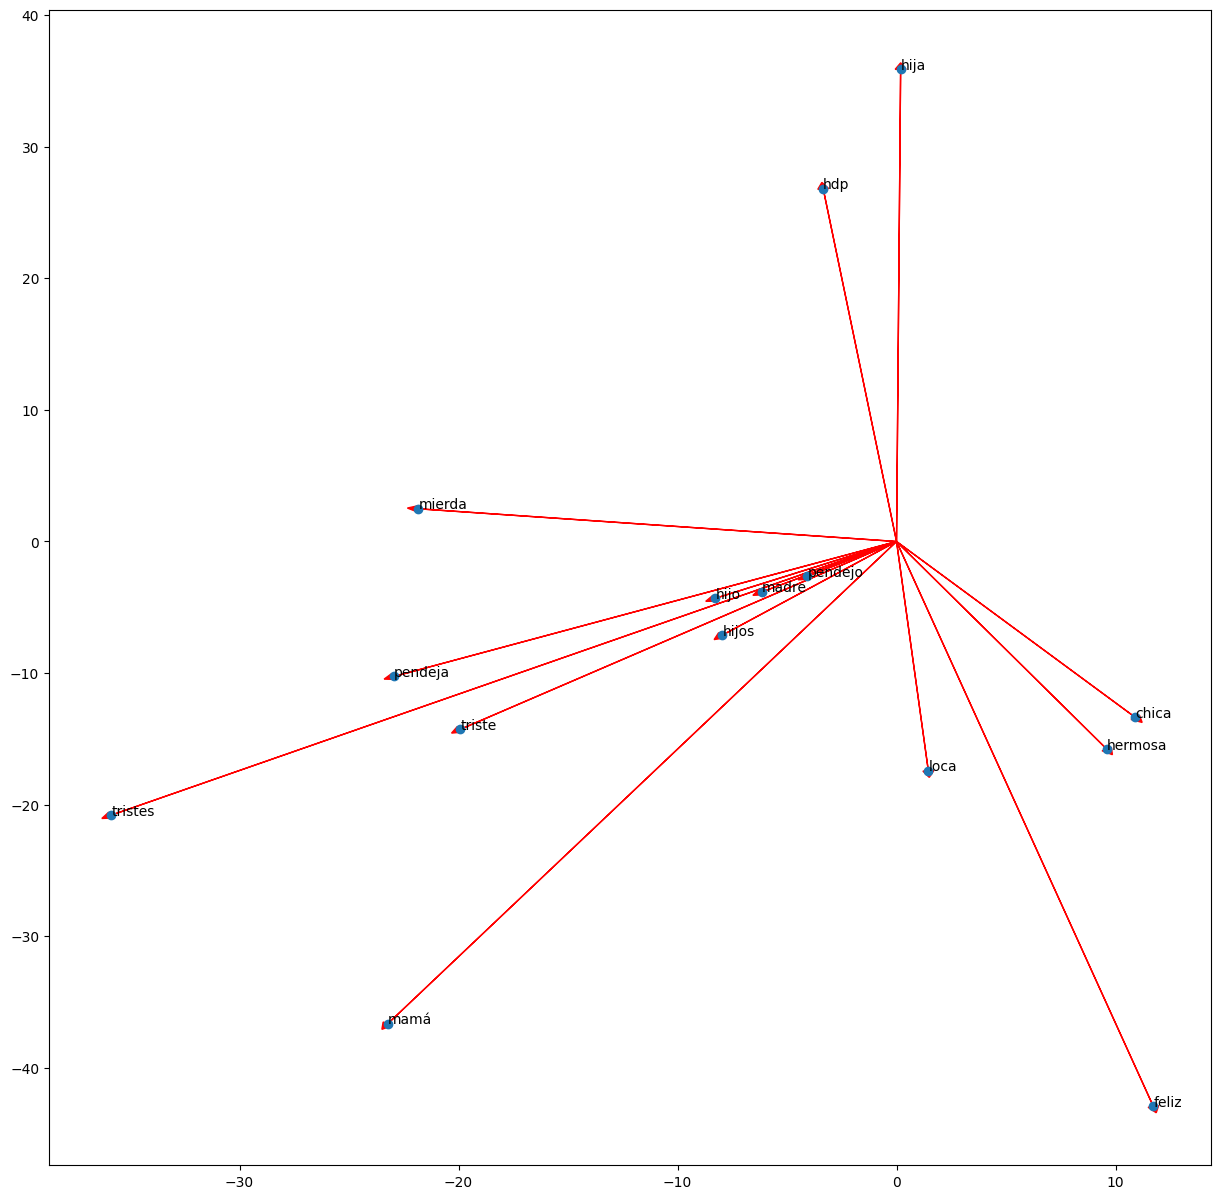

In [65]:
subsetwords = ["tristes", "triste", "feliz", "hermosa", "chica", "hombres", "hdp", "madre", "madres", "@usuario", "hijos", "pendeja", "pendejo", "mierda", "loca", "hijo", "hija", "mamá", "tía"]

ploted_subsetwords = []
subreduced_matrix = []
for idx, word in enumerate(t_words):
    if word in subsetwords:
        ploted_subsetwords += [word]
        subreduced_matrix += [reduced_matrix[idx]]

subreduced_matrix = np.array(subreduced_matrix)

fig, ax = plt.subplots(figsize=(15,15))

col1 = 0
col2 = 1

for word in subreduced_matrix:
    ax.arrow(0, 0, word[col1], word[col2], head_width=0.5, head_length=0.5, fc='r', ec='r')

ax.scatter(subreduced_matrix[:,0], subreduced_matrix[:,1])

for i in range(len(ploted_subsetwords)):
    ax.annotate(ploted_subsetwords[i], (subreduced_matrix[i,col1], subreduced_matrix[i,col2]))

plt.show()

# Clasificacion de documentos

## TCOR

Decide usarse la representacion TCOR para construir los vectores de documento, dado que parece mostrar una mejor agrupacion de los terminos (lo que podria volver mas acertada la clasificacion de los documentos)

In [15]:
target_matrix = TCOR_base[best]
target_matrix = target_matrix[:,best]
target_matrix.shape

(1000, 1000)

Calculo de centroides de documento

In [26]:
from sklearn import preprocessing

centroides_tr = np.zeros((BOW_tr.shape[0], TCOR_base.shape[1]), dtype=np.float64)

for i in range(BOW_tr.shape[0]):
    # Extraemos los pesos del documento i
    pesos = BOW_tr[i]
    suma_pesos = np.sum(pesos)
    
    if suma_pesos > 0:
        # Calculamos la suma ponderada de los vectores de término
        suma_ponderada = np.dot(pesos, TCOR_base)
        # Dividimos por la suma de los pesos para obtener la media (centroide)
        centroides_tr[i] = suma_ponderada / suma_pesos
    else:
        # Si el documento no contiene términos, se asigna un vector cero
        centroides_tr[i] = np.zeros(TCOR_base.shape[1])

centroides_tr = preprocessing.normalize(centroides_tr, norm='l2')

In [18]:
val_txt, val_y = get_texts_from_file("../../Corpus/mex20_val.txt", "../../Corpus/mex20_val_labels.txt")
val_y = [int(y) for y in val_y]

In [27]:
BOW_val = build_bow_tr(val_txt, V, dict_indices)
TCOR_val = compute_tcor(BOW_val)
TCOR_val = preprocessing.normalize(TCOR_val, norm='l2')

DOR: Shape of the input matrix (BoT):  (587, 5000)
DOR: Shape of the term-feat matrix:  (5000, 5000)


In [28]:
centroides_val = np.zeros((BOW_val.shape[0], TCOR_val.shape[1]), dtype=np.float64)

for i in range(BOW_val.shape[0]):
    # Extraemos los pesos del documento i
    pesos = BOW_val[i]
    suma_pesos = np.sum(pesos)
    
    if suma_pesos > 0:
        # Calculamos la suma ponderada de los vectores de término
        suma_ponderada = np.dot(pesos, TCOR_val)
        # Dividimos por la suma de los pesos para obtener la media (centroide)
        centroides_val[i] = suma_ponderada / suma_pesos
    else:
        # Si el documento no contiene términos, se asigna un vector cero
        centroides_val[i] = np.zeros(TCOR_val.shape[1])

centroides_val = preprocessing.normalize(centroides_val, norm='l2')

In [29]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_recall_fscore_support, roc_auc_score

reports = []

parameters = {'C': [.05, .12, .25, .5, 1, 2, 4]}

svr = svm.LinearSVC(class_weight='balanced')
grid = GridSearchCV(estimator=svr, param_grid=parameters, n_jobs=8, scoring='f1_macro', cv=5)

grid.fit(centroides_tr, tr_y)

y_pred = grid.predict(centroides_val)

p, r, f = precision_recall_fscore_support(val_y, y_pred, average='macro', pos_label=1)[:3]

print(confusion_matrix(val_y, y_pred))
reports.append(metrics.classification_report(val_y, y_pred, output_dict=True))

[[359  59]
 [ 74  95]]


## BoW-TFIDF

In [22]:
# Construccion de la matriz de BOW, donde cada fila es un documento y cada columna una palabra donde se indica si esta presente o no
def build_bow_weighing(tr_txt, V_dict, weighing_scheme):
    '''
        tr_txt: lista de documentos (strings), 
        V: diccionario de palabras ( word, (indice, freq) ),
        weighing_scheme: 0 (binario), 1 (frecuencia), 2 (tf-idf), 3 (binario normalizado), 4 (frecuencia normalizado), 5 (tf-idf normalizado)
    '''
    BOW = np.zeros((len(tr_txt), len(V_dict.keys())),dtype=int)
    
    for doc_idx, tr in enumerate(tr_txt):
        fdist_doc = nltk.FreqDist(tokenizer.tokenize(tr))
        for word in fdist_doc:
            if word in V_dict: # en caso de que la palabra no este en el diccionario recortado
                if weighing_scheme in [0,3]: # binario
                    BOW[doc_idx, V_dict[word]] = 1
                else: # frecuencia
                    BOW[doc_idx, V_dict[word]] = fdist_doc[word]
                    if weighing_scheme in [2,5]: # tf-idf regular o normalizado
                        #nonzero_mask = BOE[doc_idx] > 0
                        #BOW[doc_idx, nonzero_mask] = 1 + np.log10(BOW[doc_idx, nonzero_mask])
                        BOW[doc_idx, V_dict[word]] = np.where(BOW[doc_idx, V_dict[word]]>0, 1 + np.log10(BOW[doc_idx, V_dict[word]]), 0)
    if weighing_scheme in [2,5]: # producto idf
        BOW = BOW * np.log10(len(tr_txt)/(1+np.count_nonzero(BOW, axis=0)))
    if weighing_scheme > 2:
        l2 = np.linalg.norm(BOW, axis=1, keepdims=True)
        BOW = np.where(l2>0, BOW/l2, 0)
    return BOW

In [23]:
V_dict = dict([(word, i) for i, (freq, word) in enumerate(V)])

BOW_tfidf_tr = build_bow_weighing(tr_txt, V_dict, 2)
BOW_tfidf_val = build_bow_weighing(val_txt, V_dict, 2)

In [31]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_recall_fscore_support, roc_auc_score

parameters = {'C': [.05, .12, .25, .5, 1, 2, 4]}

svr = svm.LinearSVC(class_weight='balanced')
grid = GridSearchCV(estimator=svr, param_grid=parameters, n_jobs=8, scoring='f1_macro', cv=5)

grid.fit(BOW_tfidf_tr, tr_y)

y_pred = grid.predict(BOW_tfidf_val)

p, r, f = precision_recall_fscore_support(val_y, y_pred, average='macro', pos_label=1)[:3]

print(confusion_matrix(val_y, y_pred))
reports.append(metrics.classification_report(val_y, y_pred, output_dict=True))

/home/juancho/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/juancho/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/juancho/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/juancho/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/juancho/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/juancho/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinea

[[365  53]
 [ 65 104]]


Al comparar ambos acercamientos, se observan resultados muy similares, siendo la BoW la que posee el mayor puntaje F1, si bien por tan solo alrededor de 0.03

In [32]:
import pandas as pd
results = pd.DataFrame({
    "weighing scheme": ["tcor", "bow"],
    "f1": [report["macro avg"]["f1-score"] for report in reports],
    "accuracy": [report["accuracy"] for report in reports],
    "precision": [report["macro avg"]["precision"] for report in reports],
})
results

,weighing scheme,f1,accuracy,precision
0,tcor,0.715974,0.773424,0.722991
1,bow,0.749443,0.798978,0.755629


# Similitud de terminos

Para medir la similitud entre los terminos, la matriz TCOR construida se multiplicara por su traspuesta para obtener la comparacion con el coseno

In [159]:
similarity_matrix = np.dot(TCOR_base, TCOR_base.T)
similarity_matrix = np.triu(similarity_matrix, k=1)
similarity_matrix

array([[0.        , 0.89906128, 0.89620504, ..., 0.11947974, 0.13049819,
        0.15524425],
       [0.        , 0.        , 0.89698786, ..., 0.11958429, 0.12800682,
        0.15571594],
       [0.        , 0.        , 0.        , ..., 0.12898138, 0.13846341,
        0.15651872],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.19189584,
        0.29796601],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.14634327],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [160]:
# indices de los 10 terminos mas similares
top10_flat_idx = np.argsort(similarity_matrix, axis=None)[-10:]
top10_flat_idx = top10_flat_idx[::-1]
top10_idx = np.unravel_index(top10_flat_idx, similarity_matrix.shape)
top10_idx

(array([ 128, 4677, 3976, 3330, 3330, 3608, 3641, 3330, 3330, 3641]),
 array([ 136, 4679, 4301, 3976, 4301, 4301, 3976, 3608, 3641, 4301]))

In [163]:
# Imprimir encabezados
print(f'{"Termino 1":<20} {"Termino 2":<20} {"Similitud":>10}')
print("-" * 55)

# Imprimir las 10 filas
for i in range(10):
    name1 = V[top10_idx[0][i]][1]
    name2 = V[top10_idx[1][i]][1]
    similarity = similarity_matrix[top10_idx[0][i], top10_idx[1][i]]
    print(f'{name1:<20} {name2:<20} {similarity:>10.4f}')


Termino 1            Termino 2             Similitud
-------------------------------------------------------
“                    ”                        0.9635
TENGAN               TANTITA                  0.9625
grupitos             coparmex                 0.9624
simpatizantes        grupitos                 0.9624
simpatizantes        coparmex                 0.9624
pedorros             coparmex                 0.9624
opus                 grupitos                 0.9624
simpatizantes        pedorros                 0.9624
simpatizantes        opus                     0.9624
opus                 coparmex                 0.9624


# Similitud de documentos

Para medir la similitud de documentos, se realiza un procedimiento analogo al anterior, ahora con la matriz de vectores de documentos centroides_tr

In [71]:
def comparten_tokens(tokens1, tokens2, umbral):
    """
    Retorna True si tokens1 y tokens2 comparten al menos 'umbral' tokens en común.
    """
    comunes = set(tokens1) & set(tokens2)
    return len(comunes) >= umbral

def filtrar_indices(texts):
    """
    Recorre la lista de textos tokenizados y retorna los índices de aquellos textos que
    no comparten al menos 'umbral' tokens con ninguno de los textos ya aceptados.
    """
    tokenized = [tokenizer.tokenize(text) for text in tr_txt]
    indices_filtrados = []
    for idx, tokens in enumerate(tokenized):
        umbral = len(tokens) // 2
        # Comparar con cada texto ya aceptado (por sus índices)
        if not any(comparten_tokens(tokens, tokenized[i], umbral) for i in indices_filtrados):
            indices_filtrados.append(idx)
    return indices_filtrados


In [80]:
idx_filtrados = filtrar_indices(tr_txt)
filtered_txt = [tr_txt[i] for i in idx_filtrados]
filtered_y = [tr_y[i] for i in idx_filtrados]

In [73]:
filtered_centroides = centroides_tr[idx_filtrados]
similarity_doc_matrix = np.dot(filtered_centroides, filtered_centroides.T)
similarity_doc_matrix = np.triu(similarity_doc_matrix, k=1)
similarity_doc_matrix

array([[0.        , 0.88231244, 0.88165756, ..., 0.85324042, 0.89281503,
        0.87843156],
       [0.        , 0.        , 0.89231002, ..., 0.87063094, 0.91462397,
        0.89306843],
       [0.        , 0.        , 0.        , ..., 0.8836333 , 0.92742235,
        0.92783576],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.88769488,
        0.89743643],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.92807371],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [74]:
# indices de los 10 terminos mas similares
top10doc_flat_idx = np.argsort(similarity_doc_matrix, axis=None)[-10:]
top10doc_flat_idx = top10doc_flat_idx[::-1]
top10doc_idx = np.unravel_index(top10doc_flat_idx, similarity_doc_matrix.shape)
top10doc_idx

(array([ 453, 3994,  821,  749,  749,  108,  763,  214, 3435, 3337]),
 array([3136, 4196, 2836, 1609, 1472, 2370, 2687, 4196, 4196, 3884]))

In [82]:
# Encabezado de columnas
print(f'{"Clase":<10} {"Texto":<80}')
print('-' * 90)

# Imprimir 10 pares de textos
for i in range(10):
    clase1 = filtered_y[top10doc_idx[0][i]]
    clase2 = filtered_y[top10doc_idx[1][i]]
    
    text1 = filtered_txt[top10doc_idx[0][i]]
    text2 = filtered_txt[top10doc_idx[1][i]]
    valor = similarity_doc_matrix[clase1, clase2]  # Puedes usar este valor para algún propósito adicional si lo requieres

    # Imprimir el primer texto con su índice
    print(f'{clase1:<10} {text1:<80}')
    # Imprimir el segundo texto con su índice
    print(f'{clase2:<10} {text2:<80}')
    # Separador entre cada par
    print('-' * 90)



Clase      Texto                                                                           
------------------------------------------------------------------------------------------
0          ¿Por qué me pusiste el examen más cabrón al último, señor? ¡¿POR QUÉÉÉ?! Vale verga 😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭

0          ¿Por qué me pusiste la materia más importante y cabrona con la maestra más culo, señor? ¡¿POR QUÉÉÉ, WEEEE?! 😭😭😭😭😭😭😭😭

------------------------------------------------------------------------------------------
0          Si lo tengo que pedir no lo quiero, y si no te nace pues a chingar a su madre.
 
0          Estoy en una etapa de mi vida en la que no necesito impresionar a nadie, si te agrada como soy, perfecto y si no, pues a chingar su madre.

------------------------------------------------------------------------------------------
1          Clima de la verga, trafico de la chingada por todos lados, gente caótica estos son los estragos de que @USUARIO no halla co

# Chi2 y top 50 terminos

In [175]:
def chi2(idx, BOW, y):
    '''
        idx: indice de la palabra a evaluar
        BOW: matriz de BOW
        y: etiquetas
    '''
    N = BOW.shape[0] # numero de documentos
    np1 = np.count_nonzero(y) # numero de documentos en la clase 1
    np0 = N - np1 # numero de documentos en la clase 0
    np_vals = [np0, np1]
    ni = np.count_nonzero(BOW[:, idx]) # numero de documentos que contienen el termino
    ni1 = np.count_nonzero(BOW[y==1, idx]) # numero de documentos en la clase 1 que contienen el termino
    ni0 = ni - ni1 # numero de documentos en la clase 0 que contienen el termino
    ni_vals = [ni0, ni1]
    
    chi2 = 0
    for i in range(2):
        chi2 += np_vals[i]*(N*ni_vals[i]-np_vals[i]*ni)**2/(ni*np_vals[i]*(N-ni)*(N-np_vals[i]))
    
    return chi2

    
def filter_chi2(BOW, y):
    relevant_k_idx = [(i, chi2(i, BOW, y)) for i in range(BOW.shape[1])]
    relevant_k_idx = sorted(relevant_k_idx, key=lambda x: x[1], reverse=True)
    return relevant_k_idx

In [176]:
V = V[:10000]
# se guarda en un diccionario debido a su rapido acceso
dict_indices = dict()
cont = 0

for weight, word in V:
    dict_indices[word] = cont
    cont += 1
BOW_tr = build_bow_tr(tr_txt, V, dict_indices)

Se muestran los 50 terminos mas relevantes en el corpus, ignorando stopwords y signos de puntuacion

In [ ]:
from nltk.corpus import stopwords
import string
sw = set(stopwords.words("spanish"))

relevant_idx = filter_chi2(BOW_tr, tr_y)
top50_list = [(V[i][1].lower(), chi) for i, chi in relevant_idx if (V[i][1].lower() not in sw) and (V[i][1] not in string.punctuation+'¡…¿...”\0') and V[i][1].isalpha()]
top50_list = top50_list[:50]
top50_dict = dict(top50_list)
top50_dict

{'verga': 304.2932273505555,
 'madre': 297.45330676727036,
 'putas': 214.3496100878603,
 'putos': 201.6937639172415,
 'si': 63.67257228505246,
 'loca': 149.16358533964058,
 'gorda': 123.0968036631923,
 'bien': 104.2675835546358,
 'feas': 93.20820707252038,
 'ser': 76.17225325884544,
 'puta': 66.67676721368261,
 'puto': 65.38824942899522,
 'pinche': 64.53007596006034,
 'tan': 63.24407137527237,
 'así': 54.28401495112591,
 'mamar': 53.00997197664117,
 'joto': 49.619769474548406,
 'cosas': 48.77386138899716,
 'vida': 47.92860879208252,
 'hace': 46.661957272214316,
 'ver': 46.661957272214316,
 'mejor': 46.240067018919724,
 'solo': 45.81834006744565,
 'vale': 43.712151522090736,
 'va': 43.712151522090736,
 'marica': 43.712151522090736,
 'quiero': 43.29140239338983,
 'gente': 42.870815904475826,
 'siempre': 42.45039196106478,
 'día': 42.03013046894563,
 'voy': 42.03013046894563,
 'vez': 39.511967726703304,
 'q': 38.67387549716072,
 'mierda': 37.83642969432816,
 'luchona': 36.99962957060341,


Me marca este error que no supe como corregir, compare mi diccionario y el codigo que uso para la grafica con otros companeros pero no encuentro el problema

In [201]:
from wordcloud import WordCloud

wordcloud = WordCloud(background_color='white').generate_from_frequencies(top50_dict)

import matplotlib.pyplot as plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

ValueError: Only supported for TrueType fonts